In [1]:
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from photutils.aperture import CircularAperture, aperture_photometry, CircularAnnulus, ApertureStats
from photutils.psf import ImagePSF
from photutils.psf import PSFPhotometry
from astropy.stats import SigmaClip
from photutils.detection import find_peaks, DAOStarFinder
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.table import Table
from photutils.background import LocalBackground, MMMBackground


In [2]:
#Read a star cluster set of images

combinepath='./data/Redux/Combined/'
target = 'M103'

hdug = fits.open(combinepath+'/Combined_{}_G.fits'.format(target))
hdur = fits.open(combinepath+'/Combined_{}_R.fits'.format(target))
hdui = fits.open(combinepath+'/Combined_{}_I.fits'.format(target))
hdugsh = fits.open(combinepath+'/Combined_{}_G_shortexp.fits'.format(target))
hdursh = fits.open(combinepath+'/Combined_{}_R_shortexp.fits'.format(target))
hduish = fits.open(combinepath+'/Combined_{}_I_shortexp.fits'.format(target))


ima_g = hdug[0].data
var_g = hdug[1].data
ima_gsh = hdugsh[0].data
var_gsh = hdugsh[1].data
abzp_g = -2.5*np.log10(1e-17 * 4770**2/3e18)-48.6

epsf_g = ImagePSF(hdug[4].data)


ima_r = hdur[0].data
var_r = hdur[1].data
ima_rsh = hdursh[0].data
var_rsh = hdursh[1].data
abzp_r = -2.5*np.log10(1e-17 * 6231**2/3e18)-48.6

wcsr = WCS(hdur[0].header)
epsf_r = ImagePSF(hdur[4].data)

ima_i = hdui[0].data
var_i = hdui[1].data
ima_ish = hduish[0].data
var_ish = hduish[1].data
abzp_i = -2.5*np.log10(1e-17 * 7625**2/3e18)-48.6

print(abzp_g)
print(abzp_r)
print(abzp_i)


21.700211241598588
21.120014380525355
20.681603896705035


In [3]:
#Find Daophot stars

dao_finder = DAOStarFinder(15.0*np.sqrt(np.nanmedian(var_r)),4.0)
daostars = dao_finder.find_stars(ima_r)
print('Number of stars found: {}'.format(len(daostars)))

daostars['mag']+=abzp_r
#sort table based on a column
daostars.sort('mag')

#Derive ra and dec
rag, deg = wcsr.wcs_pix2world(daostars['xcentroid'], daostars['ycentroid'],0)

daostars['RA'] = rag
daostars['DEC'] = deg

print(daostars)


Number of stars found: 3740
 id      xcentroid      ...         RA                DEC        
---- ------------------ ... ------------------ ------------------
3523 1657.6579951323624 ... 23.524875537376495 60.942772660061486
1706  2312.541923452393 ... 23.318019841217858  60.63374779837627
2215 292.76811565387595 ...  23.95154211325414 60.689904231468425
2994 1151.3103279540157 ... 23.683585317739087 60.815537494187595
1955 2206.0332734543736 ...  23.35138278299852  60.66243350984528
1301  4321.404784196882 ... 22.690184723987205  60.57392439391432
2407  1509.679175677508 ... 23.570021792632453  60.71736257247473
1950 2314.4359667524063 ... 23.317408746297964 60.662063014284094
1272   2178.30468449287 ... 23.360009947433547  60.57031124236162
 960   2704.74011605709 ...   23.1957230389637 60.517704550452066
 ...                ... ...                ...                ...
 165 1377.3509875816965 ... 23.608650349153464  60.37118923661885
 235 1357.7490400115435 ... 23.614891285805342  

 id      xcentroid         ycentroid         sharpness      roundness1     roundness2     npix    peak      flux      mag    daofind_mag         RA                DEC        
---- ----------------- ----------------- ------------------ ---------- ------------------ ---- --------- --------- --------- ----------- ------------------ ------------------
3014 2585.104054627869 3330.399978497526 0.4353464710489581 0.21250066 0.1882418388744829   25 195.81918 2934.3813 12.451222  -4.8567333 23.232062278224458 60.819623989828415


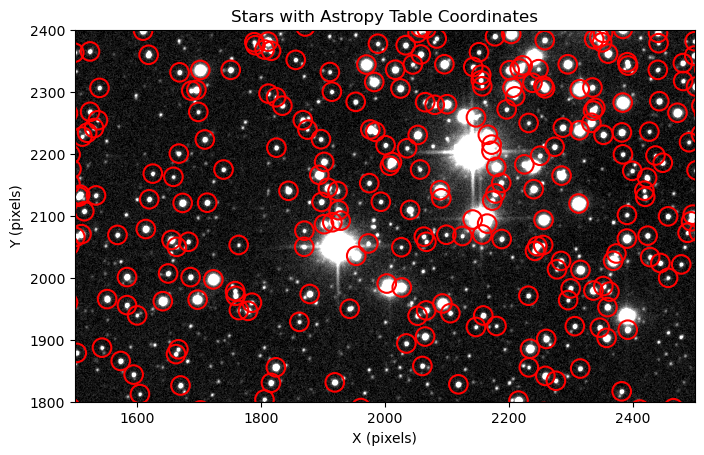

In [4]:
# Display image
# origin='lower' is standard for astronomical images (FITS) where (0,0) is bottom-left
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(ima_r, cmap='gray', origin='lower', vmin=-0.1, vmax=1)

# Loop through the table and draw circles
for row in daostars:
    # Create a circle patch
    # Center is (x, y), radius can be fixed or scaled
    circle = Circle((row['xcentroid'], row['ycentroid']), radius=15, edgecolor='red', facecolor='none', linewidth=1.5)
    ax.add_patch(circle)

ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.set_title('Stars with Astropy Table Coordinates')
ax.set_xlim(1500,2500)
ax.set_ylim(1800,2400)

print(daostars[37])


In [5]:
def run_aperturephot(ima, error,  starpos, zp):

    rap = 15

    apertures = CircularAperture(starpos, r=rap)
    annulus = CircularAnnulus(starpos, r_in=rap, r_out=rap+2)

    sigclip = SigmaClip(sigma=3.0, maxiters=10)
    aper_stats = ApertureStats(ima, apertures, sigma_clip=None)
    bkg_stats = ApertureStats(ima, annulus, sigma_clip=sigclip)
    bkg_sum = bkg_stats.median * aper_stats.sum_aper_area.value

    ap_mag= -2.5*np.log10(aper_stats.sum - bkg_sum)+zp

    saturated = aper_stats.sum_aper_area.value<(np.pi*rap**2)-1
    ap_mag[saturated]= -99

    undet = aper_stats.sum - bkg_sum<0
    ap_mag[undet] = 25

    return ap_mag

In [6]:
#Read membership table

if target=='M103':
        membertab = Table.read('StarTracks/M103_membership.fits')
        print(membertab.colnames)
        pthresh = 61
        keep = (membertab['Ps']==1) & (membertab['Pkin']>pthresh) & (membertab['PJKs']>pthresh) & (membertab['PJH']>pthresh)
        membertab = membertab[keep]

        membertab.write('StarTracks/M103_membership_selected.fits', overwrite=True)

        ra = membertab['RAhour']*15
        dec = membertab['DEdeg']

        xpos, ypos = wcsr.wcs_world2pix(ra, dec, 1)
        xpos = np.array(xpos)
        ypos = np.array(ypos)


else:
        xpos=daostars['xcentroid']
        ypos=daostars['ycentroid']

#Repeat aperture photometry with these positions
star_pos = np.column_stack((xpos, ypos))

member_rmag = run_aperturephot(ima_r, var_r, star_pos, abzp_r)
member_gmag = run_aperturephot(ima_g, var_g, star_pos, abzp_g)
member_imag = run_aperturephot(ima_i, var_i, star_pos, abzp_i)

saturated = (member_rmag<-90) | (member_gmag<-90) | (member_imag<-90)
star_pos_sat = np.column_stack((xpos[saturated], ypos[saturated]))

tmp_rmag = run_aperturephot(ima_rsh, var_rsh, star_pos_sat, abzp_r)
tmp_gmag = run_aperturephot(ima_gsh, var_gsh, star_pos_sat, abzp_g)
tmp_imag = run_aperturephot(ima_ish, var_ish, star_pos_sat, abzp_i)

member_rmag[saturated] = tmp_rmag
member_gmag[saturated] = tmp_gmag
member_imag[saturated] = tmp_imag

#bad = (member_rmag>15) & (member_rmag <17) & (member_gmag-member_rmag<0.2)
#print(star_pos[bad],member_rmag[bad], member_gmag[bad])


['RAhour', 'DEdeg', 'Bmag', 'Vmag', 'Jmag', 'Hmag', 'Ksmag', 'e_Jmag', 'e_Hmag', 'e_Ksmag', 'pmRA', 'pmDE', 'e_pm', 'RV', 'e_RV', 'Qflg', 'Rflg', 'Bflg', '2MASS', 'ASCC', 'SpType', 'Rcl', 'Ps', 'Pkin', 'PJKs', 'PJH', 'MWSC']


/var/folders/ls/6hrs6lfd0h3_n2gkfnmq_k940000gn/T/ipykernel_88772/2307019488.py:13: RuntimeWarning: invalid value encountered in log10
  ap_mag= -2.5*np.log10(aper_stats.sum - bkg_sum)+zp
/var/folders/ls/6hrs6lfd0h3_n2gkfnmq_k940000gn/T/ipykernel_88772/2307019488.py:13: RuntimeWarning: invalid value encountered in log10
  ap_mag= -2.5*np.log10(aper_stats.sum - bkg_sum)+zp
/var/folders/ls/6hrs6lfd0h3_n2gkfnmq_k940000gn/T/ipykernel_88772/2307019488.py:13: RuntimeWarning: invalid value encountered in log10
  ap_mag= -2.5*np.log10(aper_stats.sum - bkg_sum)+zp


['id', 'group_id', 'group_size', 'local_bkg', 'x_init', 'y_init', 'flux_init', 'x_fit', 'y_fit', 'flux_fit', 'x_err', 'y_err', 'flux_err', 'npixfit', 'qfit', 'cfit', 'reduced_chi2', 'flags']


[[2622.08211162 2423.32759389]
 [2636.18146082 1329.46061676]
 [2231.80772637 2666.55372862]
 [1664.88535146 2780.95155629]
 [2747.91767839 3159.37721887]
 [3009.27308945 2711.10688203]]      flux_fit     
------------------
18.368401103266606
 18.47143019312601
18.913621737505782
18.431484393869386
18.749183936412567
18.874900124322718      flux_fit     
------------------
  20.7277262795143
 19.21707433247979
21.301747407883873
20.433410607267717
20.731484667449646
 21.36857339644948


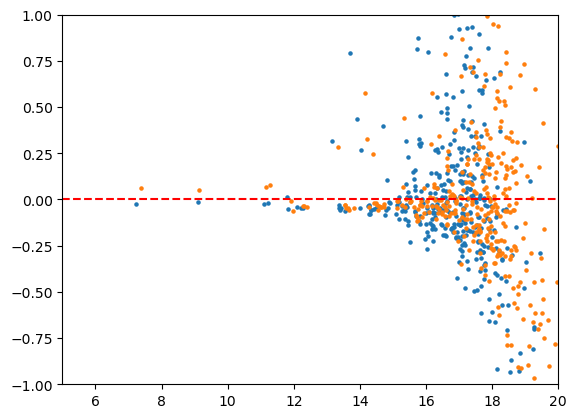

In [7]:
#Try PSF photometry for r band

from astropy.table import QTable

fit_shape = (9, 9)

init_params = QTable()
init_params['x'] = xpos
init_params['y'] = ypos

init_params2 = QTable()
init_params2['x'] = star_pos_sat[:,0]
init_params2['y'] = star_pos_sat[:,1]

localbkg_estimator = LocalBackground(10, 12, MMMBackground())

psfphot = PSFPhotometry(epsf_r, fit_shape, finder=None,aperture_radius=4,localbkg_estimator=localbkg_estimator)
phot = psfphot(ima_r, error=np.sqrt(var_r), init_params=init_params)
phot2 = psfphot(ima_rsh, error=np.sqrt(var_rsh), init_params=init_params2)
phot[saturated] = phot2

print(phot.colnames)

psfmag_r = -2.5*np.log10(phot['flux_fit'])+abzp_r
psfmag_r_err = 1.0857*phot['flux_err']/phot['flux_fit']

psfphot = PSFPhotometry(epsf_g, fit_shape, finder=None,aperture_radius=4,localbkg_estimator=localbkg_estimator)
phot = psfphot(ima_g, error=np.sqrt(var_g), init_params=init_params)
phot2 = psfphot(ima_gsh, error=np.sqrt(var_gsh), init_params=init_params2)
phot[saturated] = phot2

psfmag_g = -2.5*np.log10(phot['flux_fit'])+abzp_g
psfmag_g_err = 1.0857*phot['flux_err']/phot['flux_fit']

fig, ax = plt.subplots()
ax.scatter(member_rmag,psfmag_r-member_rmag, s=5)
ax.scatter(member_gmag,psfmag_g-member_gmag, s=5)

ax.plot(np.array((5,20)), np.array((0,0)), '--r')
ax.set_ylim(-1,1)
ax.set_xlim(5,20)

bad = (psfmag_r>17) & (psfmag_r<19) & (psfmag_g_err>0.2)
print(star_pos[bad],psfmag_r[bad], psfmag_g[bad])


In [8]:
#daostars['gmag'] = psfmag_g
#daostars['rmag'] = psfmag_r
#daostars.write('StarTracks/M29_membership_selected.fits', overwrite=True)

In [9]:
psfmag_r_bins = np.linspace(12,19,8)
perc=90
for bb in range(len(psfmag_r_bins)-1):
    inbin = (psfmag_r>=psfmag_r_bins[bb]) & (psfmag_r<psfmag_r_bins[bb+1])
    print('Rmag bin: {} - {} : Nstars = {}, Perc {} r Err = {:.3f} Perc {} g Err = {:.3f}'.format(psfmag_r_bins[bb], psfmag_r_bins[bb+1], np.sum(inbin), perc, np.nanpercentile(psfmag_r_err[inbin],perc), perc, np.nanpercentile(psfmag_g_err[inbin],perc)))

Rmag bin: 12.0 - 13.0 : Nstars = 3, Perc 90 r Err = 0.000 Perc 90 g Err = 0.000
Rmag bin: 13.0 - 14.0 : Nstars = 8, Perc 90 r Err = 0.001 Perc 90 g Err = 0.001
Rmag bin: 14.0 - 15.0 : Nstars = 18, Perc 90 r Err = 0.003 Perc 90 g Err = 0.002
Rmag bin: 15.0 - 16.0 : Nstars = 50, Perc 90 r Err = 0.007 Perc 90 g Err = 0.007
Rmag bin: 16.0 - 17.0 : Nstars = 104, Perc 90 r Err = 0.017 Perc 90 g Err = 0.020
Rmag bin: 17.0 - 18.0 : Nstars = 149, Perc 90 r Err = 0.041 Perc 90 g Err = 0.057
Rmag bin: 18.0 - 19.0 : Nstars = 51, Perc 90 r Err = 0.095 Perc 90 g Err = 0.225


 MH 
----
-2.0
-1.5
-1.0
-0.5
 0.0
 0.5


(12.0, -8.0)

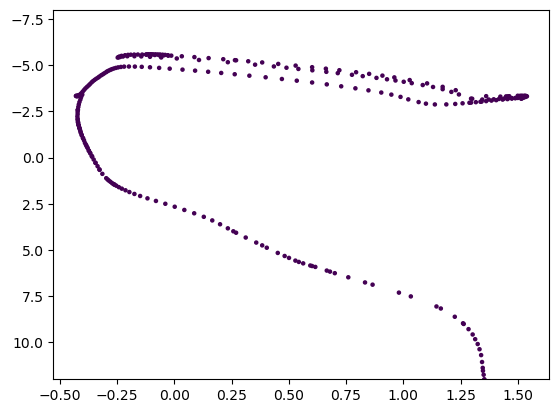

In [10]:
#Read isochrone table
#tab = Table.read('StarTracks/simulated_pop_MH-0p5_age6.5.dat', format='ascii.commented_header', header_start=13)
isotab = Table.read('StarTracks/isochrone_grid_parsec.dat', format='ascii.commented_header', header_start=13)
print(np.unique(isotab['MH']))

keep = (isotab['logAge'] == 7.6) & (isotab['MH']==0.0)

plt.scatter(isotab[keep]['gmag']-isotab[keep]['rmag'],isotab[keep]['gmag'], s=5, c=isotab[keep]['MH'], cmap='viridis')
plt.ylim(12,-8)


Dist Modulus: 12.116229369684039


Text(0, 0.5, 'r-mag')

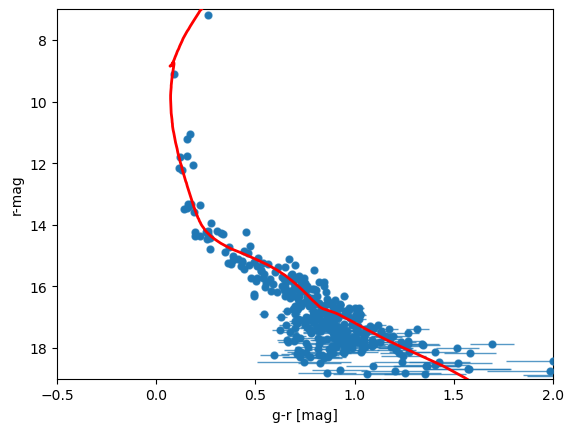

In [15]:
#Free parameters
if target=='M103':
    Av = 1.55
    DIST = 2650
    Age = 7.4
elif target=='M29':
    Av = 1.4
    DIST = 1000
    Age = 7.7
else:
    Av = 1
    DIST = 1000
    Age = 7

#Work on distances
magoff = 5*np.log10(DIST/10) #from gaia distances 2502 pc from parallax
print('Dist Modulus: {}'.format(magoff))

#Work on extinction
from dust_extinction.parameter_averages import CCM89
import astropy.units as u

ext_model = CCM89(Rv=3.1)
Ag, Ar = ext_model((0.47,0.62)*u.micron)
ext_g_r = (Ag-Ar)*Av

#Work on age
isotab = Table.read('StarTracks/isochrone_grid_parsec.dat', format='ascii.commented_header', header_start=13)
keep = (isotab['logAge'] == Age) & (isotab['MH']==-0.5)
isotab=isotab[keep]
poprmag = isotab['rmag']
popgmag = isotab['gmag']

plt.plot((popgmag-poprmag+ext_g_r), (poprmag+magoff), '-r',lw=2, zorder=100)

#plt.scatter(member_gmag-member_rmag,member_rmag, s=10)
plt.scatter(psfmag_g-psfmag_r,psfmag_r, s=15)
plt.errorbar(psfmag_g-psfmag_r, psfmag_r, xerr=np.sqrt(psfmag_g_err**2+psfmag_r_err**2), yerr=psfmag_r_err, fmt='o', ms=5, elinewidth=1, alpha=0.75, zorder=50)

#plt.scatter(membertab['Bmag']-membertab['Vmag'], membertab['Vmag'], s=5)
plt.ylim(19.0,7)
plt.xlim(-0.5,2)
plt.xlabel('g-r [mag]')
plt.ylabel('r-mag')
